In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tarfile

In [ ]:
# Path to the tar file in your Drive
tar_path = "/content/drive/MyDrive/train_images_labels_targets.tar"
extract_dir = "/content/train_data"

# Extract
with tarfile.open(tar_path, 'r') as tar_ref:
    tar_ref.extractall(extract_dir)

print("✅ Extraction complete! Files are now in:", extract_dir)

✅ Extraction complete! Files are now in: /content/train_data


In [ ]:
import glob
import os

pre_post_pairs = []

# Find all pre-disaster images
pre_imgs = glob.glob(os.path.join(extract_dir, '**/*pre_disaster.png'), recursive=True)

for pre_path in pre_imgs:
    post_path = pre_path.replace("pre_disaster", "post_disaster")
    if os.path.exists(post_path):
        pre_post_pairs.append((pre_path, post_path))

print(f"📦 Found {len(pre_post_pairs)} image pairs.")


📦 Found 2799 image pairs.


In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

# Custom dataset
class XBDPreDisasterDataset(Dataset):
    def __init__(self, pre_img_paths, transform=None):
        self.pre_img_paths = pre_img_paths
        self.transform = transform

    def __len__(self):
        return len(self.pre_img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.pre_img_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

# Image transformations
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Collect all pre-disaster image paths
pre_img_paths = [p for p, _ in pre_post_pairs]  # from earlier step

# Create dataset & loader
train_dataset = XBDPreDisasterDataset(pre_img_paths, transform=img_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [ ]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Flattened feature vector size after CNN (ResNet18 features: 512)
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 224 * 224, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 3 * 224 * 224),
            nn.Sigmoid(),  # for normalized pixel output
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(-1, 3, 224, 224)


In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("✅ Using device:", device)

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for batch in train_loader:
        batch = batch.to(device)
        output = model(batch)
        loss = criterion(output, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f" Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")


✅ Using device: cuda
 Epoch [1/10], Loss: 0.034538
 Epoch [2/10], Loss: 0.019766
 Epoch [3/10], Loss: 0.017341
 Epoch [4/10], Loss: 0.016342
 Epoch [5/10], Loss: 0.015369
 Epoch [6/10], Loss: 0.014942
 Epoch [7/10], Loss: 0.014458
 Epoch [8/10], Loss: 0.014354
 Epoch [9/10], Loss: 0.014184
 Epoch [10/10], Loss: 0.013770


In [ ]:
torch.save(model.state_dict(), "autoencoder_xbd.pth")
print(" Model saved!")


 Model saved!


In [ ]:
# Re-initialize the model and load weights
model = Autoencoder().to(device)
model.load_state_dict(torch.load("autoencoder_xbd.pth"))
model.eval()


Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=150528, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def detect_anomaly(img_path, model, transform, visualize=True):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        reconstructed = model(img_tensor)
        loss = torch.mean((img_tensor - reconstructed) ** 2, dim=1)  # per-channel MSE

    # Optional visualization
    if visualize:
        original = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
        reconstructed_img = reconstructed.squeeze().permute(1, 2, 0).cpu().numpy()
        error_map = loss.squeeze().cpu().numpy()

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(original)
        axs[0].set_title("Original Post-Disaster")
        axs[1].imshow(reconstructed_img)
        axs[1].set_title("Reconstructed Image")
        axs[2].imshow(error_map, cmap='hot')
        axs[2].set_title("Anomaly Map")
        for ax in axs:
            ax.axis("off")
        plt.tight_layout()
        plt.show()

    anomaly_score = torch.mean(loss).item()
    return anomaly_score


 Anomaly Scores:


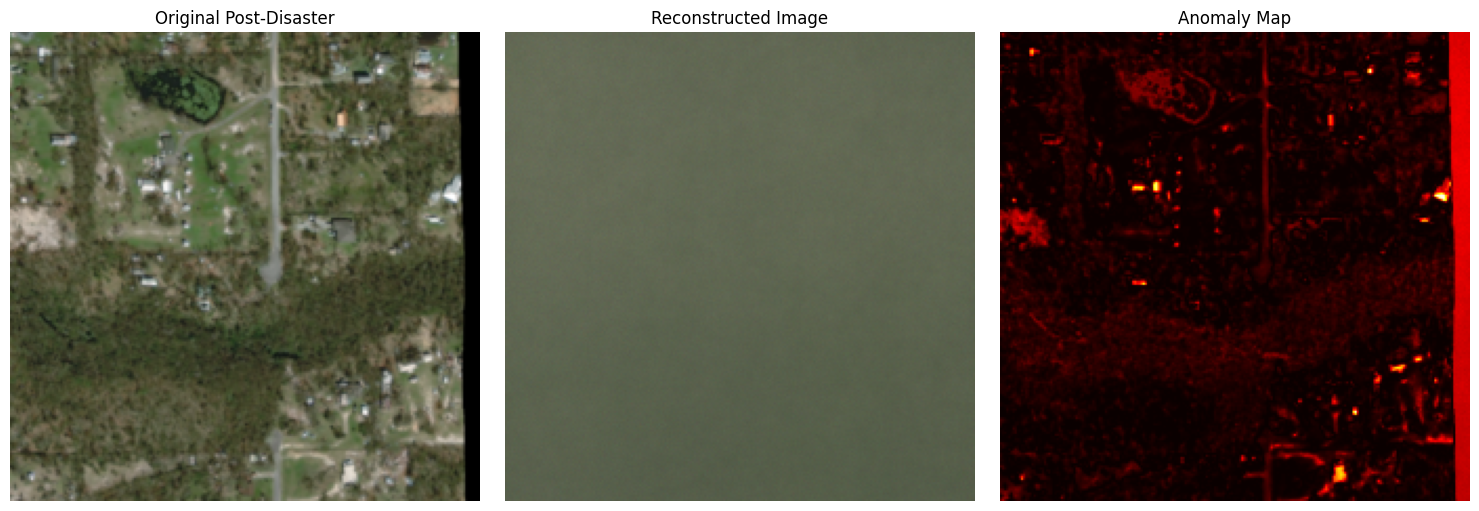

hurricane-michael_00000339_post_disaster.png → Anomaly Score: 0.017532


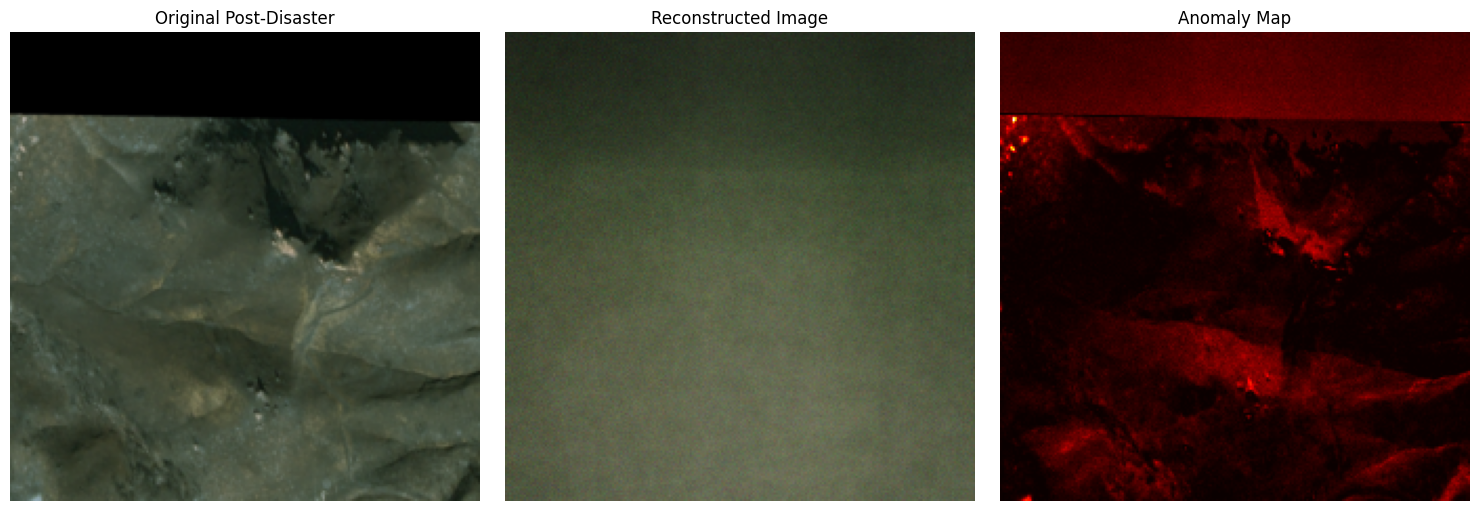

socal-fire_00000747_post_disaster.png → Anomaly Score: 0.012954


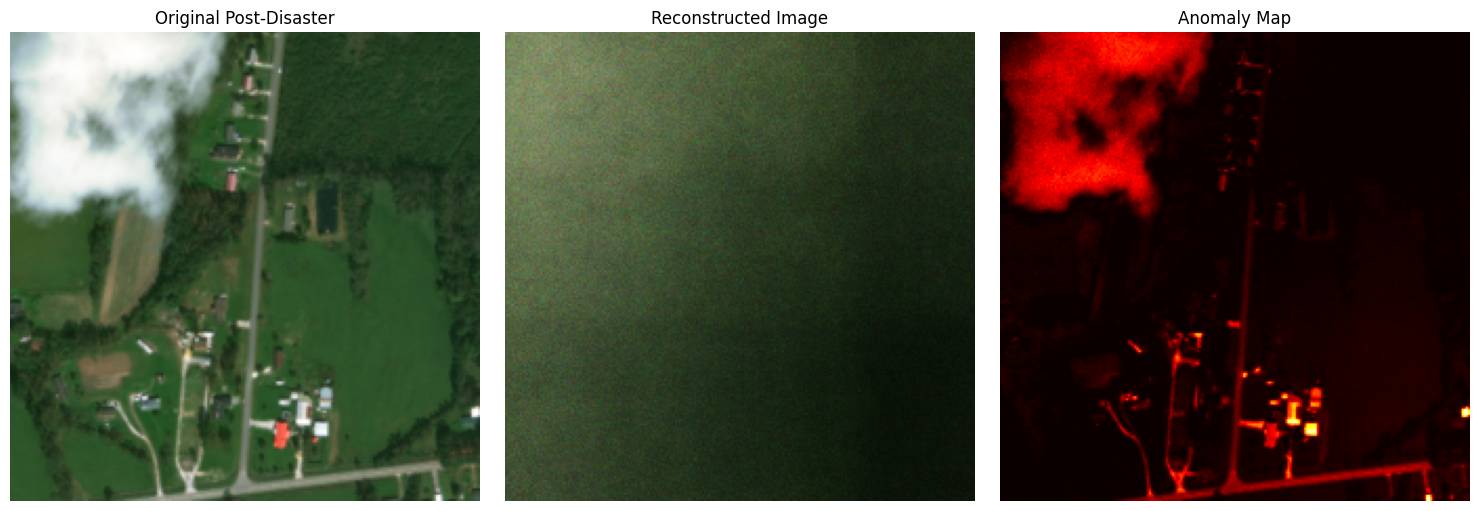

hurricane-florence_00000306_post_disaster.png → Anomaly Score: 0.046185


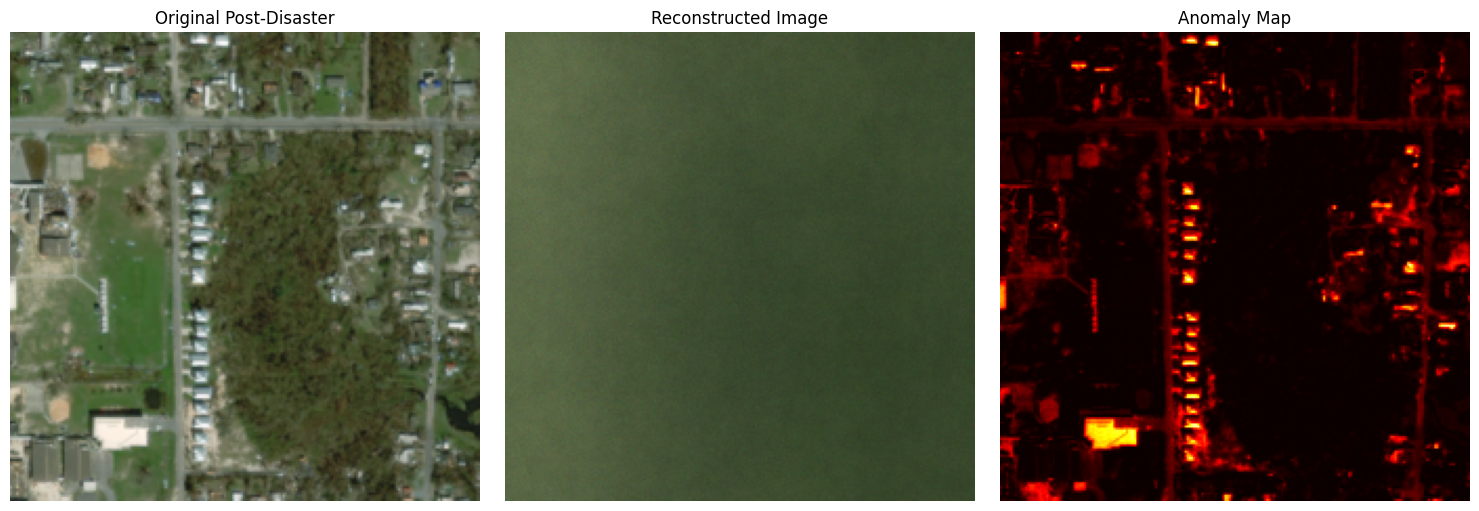

hurricane-michael_00000267_post_disaster.png → Anomaly Score: 0.023056


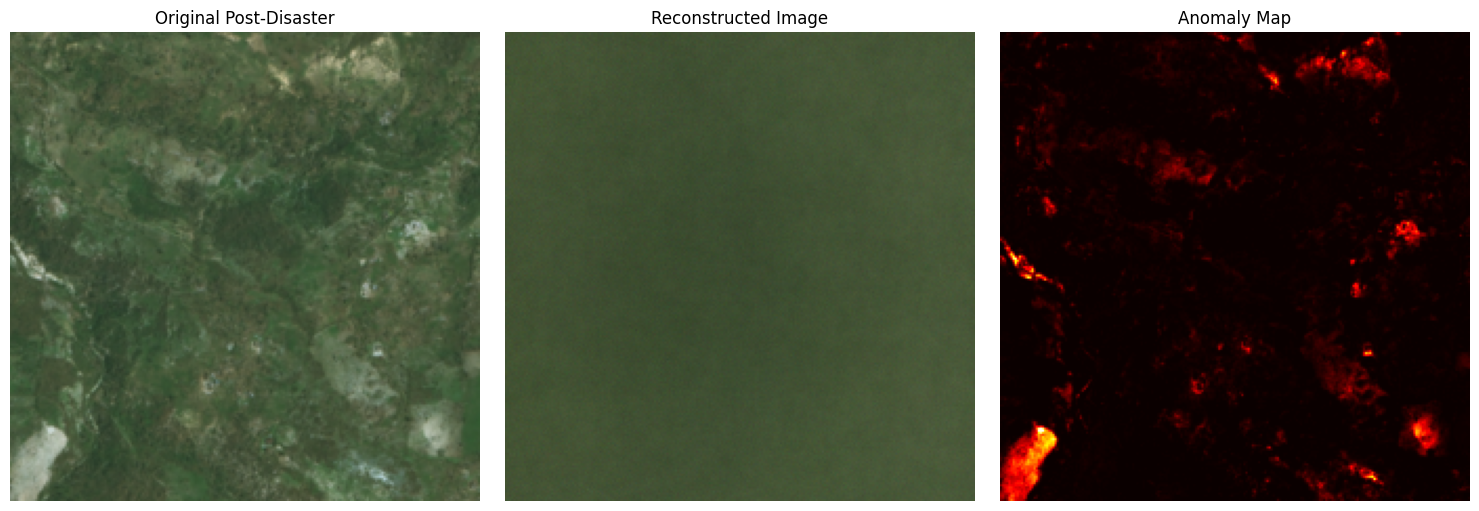

hurricane-matthew_00000168_post_disaster.png → Anomaly Score: 0.006226


In [ ]:
print(" Anomaly Scores:")
for _, post_path in pre_post_pairs[:5]:  # testing on 5 examples
    score = detect_anomaly(post_path, model, img_transform, visualize=True)
    print(f"{os.path.basename(post_path)} → Anomaly Score: {score:.6f}")


In [ ]:
threshold = 0.025  # You can tune this empirically
if score > threshold:
    print("🚨 Anomaly Detected!")
else:
    print("✅ Normal Pattern")


✅ Normal Pattern


In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

def predict_disaster_anomaly(img_input, model, transform, threshold=0.015):
    """
    Predicts whether the post-disaster image is anomalous.
    Accepts a PIL.Image or a path string.
    """
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)  # move model to device

    # Load image if it's a path
    if isinstance(img_input, str):
        img = Image.open(img_input).convert("RGB")
    else:
        img = img_input.convert("RGB")

    img_tensor = transform(img).unsqueeze(0).to(device)  # move tensor to same device

    # Run model inference
    model.eval()
    with torch.no_grad():
        reconstructed = model(img_tensor)
        loss = torch.mean((img_tensor - reconstructed) ** 2, dim=1)
        anomaly_score = torch.mean(loss).item()

    is_anomalous = anomaly_score > threshold

    # Visualization
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{'🚨 Disaster' if is_anomalous else '✅ No Disaster'}\n🧠 Score: {anomaly_score:.4f}")
    plt.show()

    return is_anomalous, anomaly_score


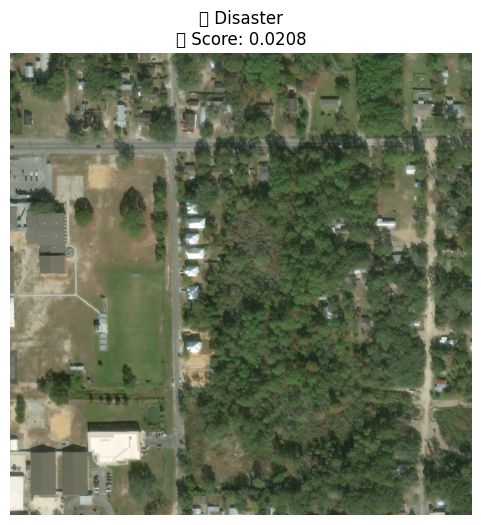

🧠 Anomaly Score: 0.020785
🚨 Disaster Detected!


In [ ]:
sample_img = pre_post_pairs[3][0]  # Use path or PIL image
is_anomaly, score = predict_disaster_anomaly(sample_img, model, img_transform)

print(f"🧠 Anomaly Score: {score:.6f}")
print("🚨 Disaster Detected!" if is_anomaly else "✅ No Anomaly Detected.")


In [ ]:
import json

sample_file = "//content/train_data/train/labels/guatemala-volcano_00000000_post_disaster.json"  # Replace with one actual file
with open(sample_file, "r") as f:
    data = json.load(f)

print(type(data))
print(data.keys())

# Now inspect the first feature
features = data.get("features", {})
lng_lat_features = features.get("lng_lat", [])
if lng_lat_features:
    print("First feature type:", type(lng_lat_features[0]))
    print("First feature content:", lng_lat_features[0])
else:
    print("No features found in 'lng_lat'")



<class 'dict'>
dict_keys(['features', 'metadata'])
First feature type: <class 'dict'>
First feature content: {'properties': {'feature_type': 'building', 'subtype': 'no-damage', 'uid': '486b0813-ecd2-4b84-856c-9c0e42156953'}, 'wkt': 'POLYGON ((-90.81544679490855 14.39086318334812, -90.81537467350067 14.39060467857134, -90.81584174451893 14.39043032647906, -90.81586635209965 14.39049581582557, -90.81593344431286 14.39048145754227, -90.81595559689623 14.39057367091926, -90.81587964155047 14.39059650626524, -90.81590706308843 14.39071123556855, -90.81544679490855 14.39086318334812))'}


In [ ]:
import os
print(os.listdir())


['.config', 'labels.csv', 'drive', 'train_data', 'autoencoder_xbd.pth', 'sample_data']


In [ ]:
import os

train_dir = "/content/train_data/train/images"
pre_disaster_images = [f for f in os.listdir(train_dir) if "_pre_disaster.png" in f]


In [ ]:
import json

def get_disaster_label(json_path):
    with open(json_path) as f:
        data = json.load(f)

    labels = [feature['properties']['subtype'] for feature in data['features']
              if feature['properties']['feature_type'] == 'building']

    # If any building is damaged (minor, major, destroyed), we label it 1
    for label in labels:
        if label in ["minor-damage", "major-damage", "destroyed"]:
            return 1
    return 0


In [ ]:
import os
import json
import pandas as pd

# Paths
base_dir = "train_data/train"
image_dir = os.path.join(base_dir, "images")
label_dir = os.path.join(base_dir, "labels")

# Prepare data
data = []

# Loop through all label files
for file in os.listdir(label_dir):
    if file.endswith("_pre_disaster.json"):
        base_name = file.replace("_pre_disaster.json", "")
        pre_image_path = os.path.join(image_dir, base_name + "_pre_disaster.png")
        post_label_path = os.path.join(label_dir, base_name + "_post_disaster.json")

        # Load the post-disaster JSON to get the label
        try:
            with open(post_label_path, 'r') as f:
                post_data = json.load(f)
                label = 1 if any(feature["properties"]["subtype"] != "no-damage"
                                 for feature in post_data["features"]["xy"]) else 0

            # Append data
            data.append({
                "image_path": pre_image_path,
                "label": label
            })

        except FileNotFoundError:
            print(f"Missing post-disaster label for: {base_name}")

# Save to CSV
df = pd.DataFrame(data)
df.to_csv("pre_disaster_dataset.csv", index=False)

print("CSV created: pre_disaster_dataset.csv")


CSV created: pre_disaster_dataset.csv


In [ ]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the CSV
df = pd.read_csv('/content/pre_disaster_dataset.csv')  # Adjust file path

# Assuming your CSV has columns 'image_path' and 'label'
image_paths = df['image_path'].values
labels = df['label'].values

# Load images
images = []
for image_path in image_paths:
    img = load_img(image_path, target_size=(224, 224))  # Resize to 224x224 for CNN input
    img = img_to_array(img)  # Convert image to array
    images.append(img)

images = np.array(images)


In [ ]:
images = images / 255.0  # Normalize image pixel values


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [ ]:
model.predict(np.zeros((1, 224, 224, 3)))  # This builds the model


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


array([[0.5461287]], dtype=float32)

In [ ]:
for layer in model.layers:
    print(layer.name)


resnet50
global_average_pooling2d
dense


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load ResNet50 without top layer for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers to avoid re-training them
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid for binary classification
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


dummy_input = np.random.rand(1, 224, 224, 3)
model.predict(dummy_input)



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


array([[0.46944275]], dtype=float32)

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 241ms/step - accuracy: 0.6158 - loss: 0.6572 - val_accuracy: 0.6357 - val_loss: 0.6586
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.6147 - loss: 0.6610 - val_accuracy: 0.6357 - val_loss: 0.6545
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.6002 - loss: 0.6654 - val_accuracy: 0.6357 - val_loss: 0.6475
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.6018 - loss: 0.6626 - val_accuracy: 0.6732 - val_loss: 0.6647
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.6405 - loss: 0.6613 - val_accuracy: 0.6357 - val_loss: 0.6460
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.6106 - loss: 0.6502 - val_accuracy: 0.6696 - val_loss: 0.6583
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.6339 - loss: 0.6553 - val_accuracy: 0.6554 - val_loss: 0.6518
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.6103 - loss: 0.6620 - val_accuracy

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.6234 - loss: 0.6555
Test accuracy: 0.6607142686843872


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


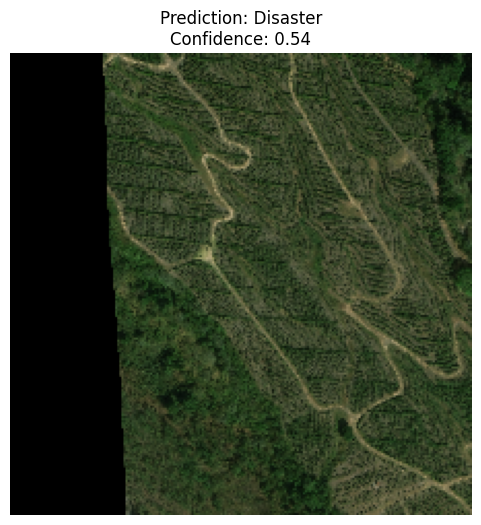

('Disaster', np.float32(0.54140925))

In [ ]:
def predict_disaster(image_path, model):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224), color_mode='rgb')
    img_array = img_to_array(img) / 255.0
    input_array = np.expand_dims(img_array, axis=0)

    # Get prediction from the model
    prediction = model.predict(input_array)[0][0]
    label = "Disaster" if prediction > 0.5 else "No Disaster"

    # Show the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(f"Prediction: {label}\nConfidence: {prediction:.2f}")
    plt.show()

    return label, prediction

# Example usage
image_path = '/content/image.png'  # Replace with your image path
predict_disaster(image_path, model)
